# **Lung Cancer Detection using Convolutional Neural Network (CNN)**

# 1. Importing Libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

from zipfile import ZipFile
import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

# 2. Importing Dataset

In [17]:
import os

data_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images"

print("Main folders:", os.listdir(data_path))

for root, dirs, files in os.walk(data_path):
    print(f"\n Folder: {root}")
    print(f"  Subfolders: {dirs[:5]} ...") 
    print(f"  Files: {files[:5]} ...")   

Main folders: ['lung_colon_image_set']

 Folder: /kaggle/input/lung-and-colon-cancer-histopathological-images
  Subfolders: ['lung_colon_image_set'] ...
  Files: [] ...

 Folder: /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set
  Subfolders: ['colon_image_sets', 'lung_image_sets'] ...
  Files: [] ...

 Folder: /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets
  Subfolders: ['colon_aca', 'colon_n'] ...
  Files: [] ...

 Folder: /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca
  Subfolders: [] ...
  Files: ['colonca637.jpeg', 'colonca3400.jpeg', 'colonca783.jpeg', 'colonca3927.jpeg', 'colonca4109.jpeg'] ...

 Folder: /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n
  Subfolders: [] ...
  Files: ['colonn2355.jpeg', 'colonn2332.jpeg', 'colonn441.jpeg', 'colonn2750.jpeg', 'colonn4467.jpeg'] ...

Classes will contain the names: 'lung_n', 'lung_aca' and 'lung_scc' corresponding to Normal, Lung Adenocarcinoma and Lung Squamous Cell Carcinoma. These are the three classes that we have here.

# 3. Visualizing the Data

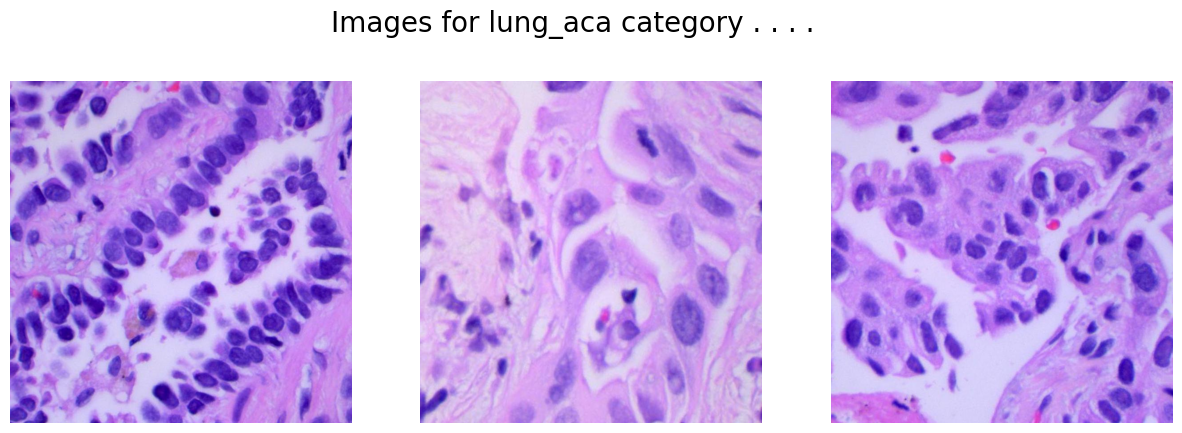

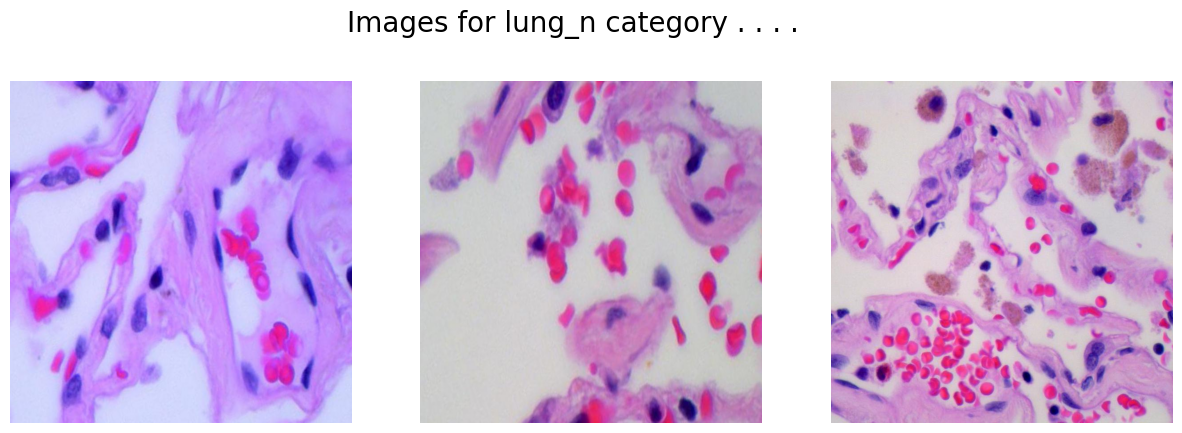

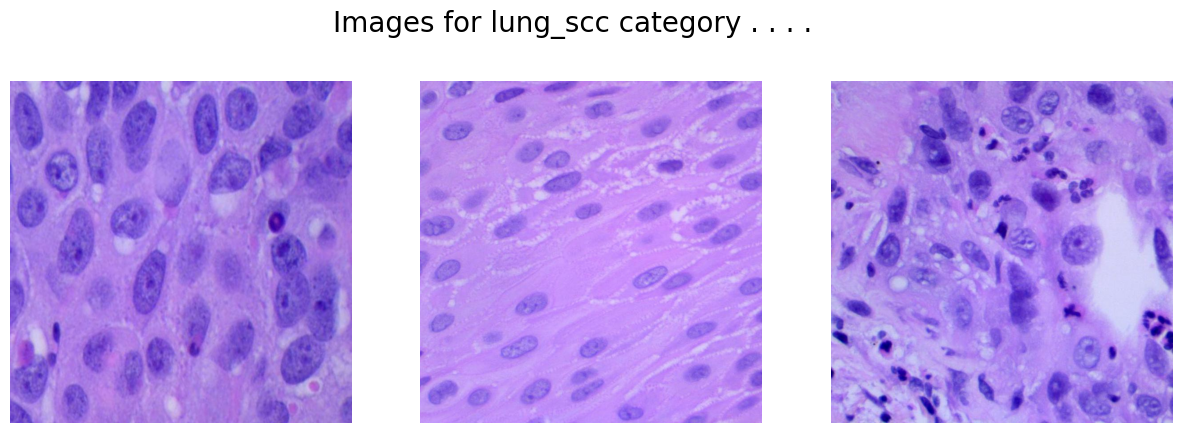

In [18]:
path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'

classes = ['lung_aca', 'lung_n', 'lung_scc']

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{image_dir}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')

    plt.show()

It selects a random sample of three images from each category and visualizes them using Matplotlib.

# 4. Preparing the Dataset
Before training the model we need to process the images into a format suitable for the CNN model. This involves resizing the images and converting them into NumPy arrays for efficient computation.

In [36]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
from tensorflow.keras.utils import to_categorical
Y = to_categorical(Y, num_classes=len(classes))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=SPLIT, random_state=2022)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=SPLIT, random_state=2022)



In [22]:
print(X_train.shape, X_val.shape,X_test.shape)

(9600, 256, 256, 3) (2400, 256, 256, 3) (3000, 256, 256, 3)


- Image Resizing: Since large images are computationally expensive to process we resize them to a standard size (256x256) using numpy array. We used 10 epochs with batch size of 64.
- One hot encoding: Labels (Y) are converted to one-hot encoded vectors using pd.get_dummies(). This allows the model to output soft probabilities for each class.
- Train-Test Split: We split the dataset into training and validation sets i.e 80% for training and 20% for validation. This allows us to evaluate the model's performance on unseen data.

# 5. Model Development

In [23]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,684,291 (128.50 MB)

 Trainable params: 33,683,523 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

# 6. Model Compilation

After defining the model architecture we will compile the model with an optimizer, loss function and evaluation metric then train it using the training data.

In [24]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True


es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

We use the Adam optimizer which adjusts the learning rate during training to speed up convergence.
Categorical cross entropy loss is appropriate as loss function for multi-class classification problems as it measures the difference between the predicted and actual probability distributions.
EarlyStopping: Stops training if validation accuracy doesn’t improve for a set number of epochs (patience).
ReduceLROnPlateau: Reduces learning rate when validation loss plateaus, controlled by patience and factor.
Custom myCallback class: Stops training early when validation accuracy exceeds 90%.
self.model.stop_training = True: Signals to stop training inside the callback.

In [25]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.7893 - loss: 0.4872 - val_accuracy: 0.5713 - val_loss: 1.8214 - learning_rate: 0.0010
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.8892 - loss: 0.2640 - val_accuracy: 0.3671 - val_loss: 6.4908 - learning_rate: 0.0010
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9028 - loss: 0.2242
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9028 - loss: 0.2241 - val_accuracy: 0.6250 - val_loss: 2.5215 - learning_rate: 0.0010
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9432 - loss: 0.1457 - val_accuracy: 0.8712 - val_loss: 0.4307 - learning_rate: 5.0000e-04
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9602 - loss: 0.1088 - val_accuracy: 0.3554 - val_loss: 13.4942 - learning_rate: 5.0000e-04
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.97

# 8. Visualizing

- pd.DataFrame(history.history) converts training history into a DataFrame.
- history_df.loc[:, ['accuracy', 'val_accuracy']].plot() plots training and validation accuracy.

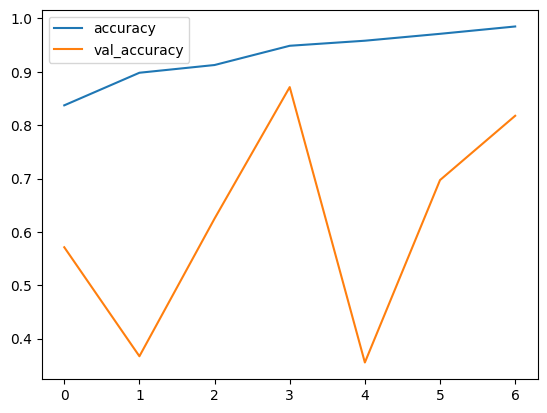

In [27]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

- This graph shows the training and validation accuracy of the model over epochs. **The training** accuracy increases steadily reaching near 1.0 indicating the model is learning well from the training data.

- However the **validation accuracy** fluctuates suggesting that the model may be overfitting where it performs well on the training data but struggles to generalize to unseen data. It can be avoided by further fine tuning the model.

# 9. Model Evaluation

In [28]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [29]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[599,   0, 197],
       [ 66, 723,   1],
       [ 45,   0, 769]])

In [30]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.84      0.75      0.80       796
      lung_n       1.00      0.92      0.96       790
    lung_scc       0.80      0.94      0.86       814

    accuracy                           0.87      2400
   macro avg       0.88      0.87      0.87      2400
weighted avg       0.88      0.87      0.87      2400



The classification report shows that the model performs well on normal lung tissue (**lung_n**) with high precision and recall resulting in a strong F1-score. However it struggles with **lung_aca** (lung adenocarcinoma) and **lung_scc** (lung squamous cell carcinoma) particularly in terms of recall. It tells us that model can be improved in handling imbalanced classes and enhancing performance across all categories.

In [42]:
from tensorflow.keras.utils import to_categorical
Y = to_categorical(Y, num_classes=len(classes))
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# Path to your manually downloaded weights file
local_weights_path = "D:\Project\efficientnetb0_notop.h5"  # <-- change this to your actual path

base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


base_model.trainable = False  # Freeze the pretrained layers

# ===============================
# 🧱 Add Custom Layers
# ===============================
model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(preprocess_input),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(len(classes), activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,302 (16.71 MB)

 Trainable params: 329,219 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

In [43]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') and logs['val_accuracy'] > 0.90:
            print("\n✅ Validation accuracy reached 90%, stopping training.")
            self.model.stop_training = True

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

In [46]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=10,
    verbose=1,
    callbacks=[es, lr, MyCallback()]
)

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.6167 - loss: 0.8549 - val_accuracy: 0.4203 - val_loss: 1.0309 - learning_rate: 0.0010
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6673 - loss: 0.6833 - val_accuracy: 0.4005 - val_loss: 0.9526 - learning_rate: 0.0010
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6978 - loss: 0.6266 - val_accuracy: 0.4318 - val_loss: 0.8710 - learning_rate: 0.0010
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.7096 - loss: 0.5803 - val_accuracy: 0.6745 - val_loss: 0.6607 - learning_rate: 0.0010
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.7220 - loss: 0.5508 - val_accuracy: 0.7083 - val_loss: 0.5938 - learning_rate: 0.0010
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.7225 - loss: 0.5346 - val_accuracy: 0.7302 - val_loss: 0.5184 - learning_rate: 0.0010
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.7251 - loss: 0.

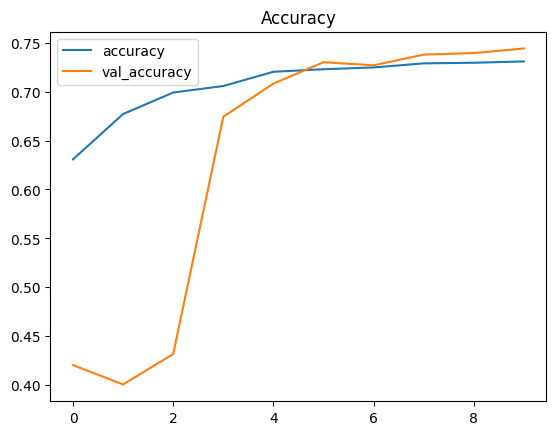

In [47]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot(title='Accuracy')
plt.show()

In [48]:
Y_pred = model.predict(X_val)
Y_val_cls = np.argmax(Y_val, axis=1)
Y_pred_cls = np.argmax(Y_pred, axis=1)

print(metrics.classification_report(Y_val_cls, Y_pred_cls, target_names=classes))
print(metrics.confusion_matrix(Y_val_cls, Y_pred_cls))

60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step
              precision    recall  f1-score   support

    lung_aca       0.60      0.64      0.62       617
      lung_n       0.98      0.93      0.96       666
    lung_scc       0.66      0.65      0.66       637

    accuracy                           0.74      1920
   macro avg       0.75      0.74      0.74      1920
weighted avg       0.75      0.74      0.75      1920

[[393  10 214]
 [ 46 620   0]
 [221   0 416]]
